Pinhole camera: model for old image taking devices and still useful for representing modern ones

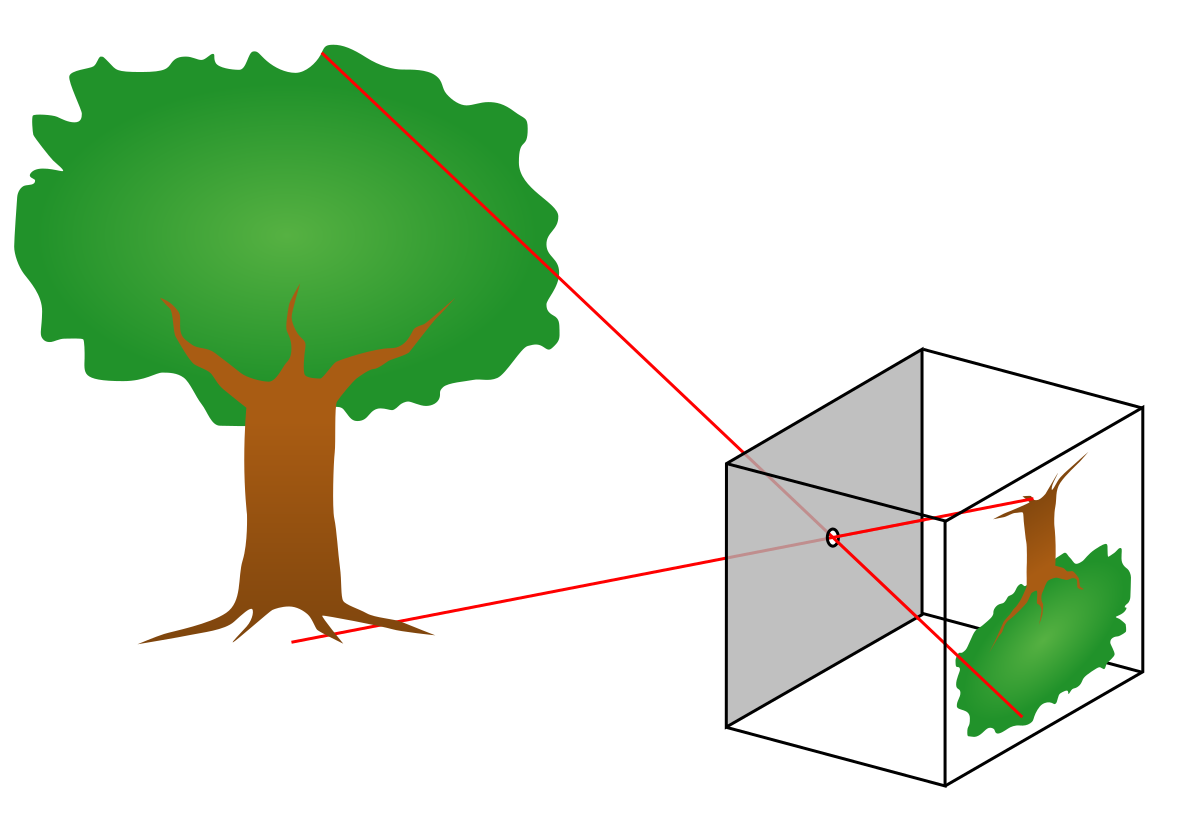

Backward ray tracing: shoot ray from every pixel and see what is hit until source of light --> What NeRF uses and more efficient computationnaly

Forward ray tracing: shoot ray from light and see what is hit before pixel

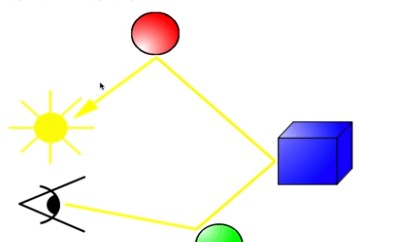

## Implementation of camera

focal length: distance between pinhole and image representation. Modifying it mofifies FoV

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import torch as torch

H=400 #height og image
W=400 #width of image
f=1200 #focal length


In [68]:
rays_o=np.zeros((H*W,3)) #ray origin for every pixel, 3D
rays_d=np.zeros((H*W,3)) #ray direction for every pixel, 3D

u = np.arange(W) #u is the x axis
v = np.arange(H) #v is the y axis

u,v=np.meshgrid(u,v) #create a grid of u and v

dirs = np.stack((u-W/2,
                -(v-H/2),
                -np.ones_like(u)*f), axis=-1) #direction of the rays, y and z are reversed wrt to image below
# dirs represents the vector from the focal point to the pixel
# to make it really a direction, we need to normalize it


rays_d = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True) #normalize the direction vectors
rays_d=rays_d.reshape(-1,3)

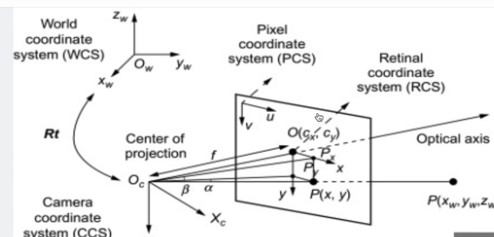

In [69]:
def plot_rays(o,d,t):
    fig=plt.figure(figsize=(12,12))
    ax= fig.add_subplot(projection="3d")

    pt1 = o #origin of ray
    pt2=o+t*d #where the head of the vector is after time t

    for p1,p2 in zip(pt1[::100], pt2[::100]): # plot one in 100 rays, will result in pyramids
        plt.plot([p1[0], p2[0]], [p1[1],p2[1]], [p1[2],p2[2]])

    #plt.plot([pt1[0,0], pt2[0,0]], [pt1[0,1],pt2[0,1]], [pt1[0,2],pt2[0,2]])

    plt.show()

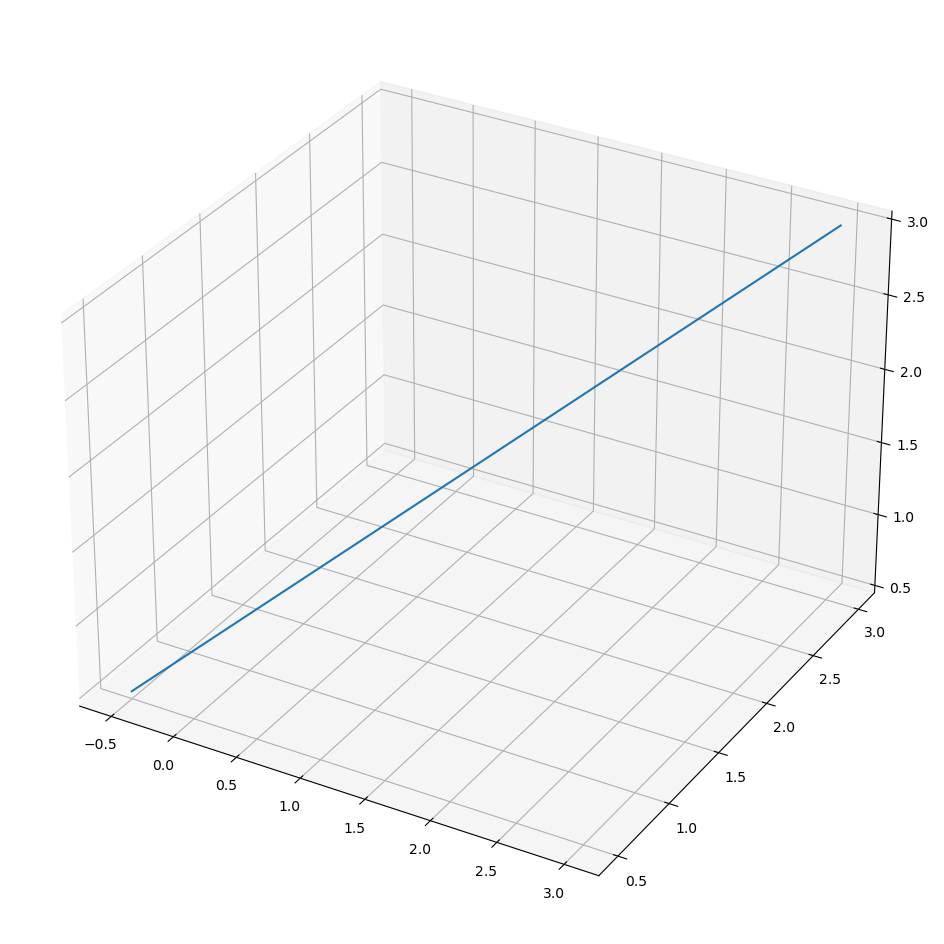

In [70]:
#test plot of a ray between two points [3,3,3] and [-0.5,0.5,0.5]
fig=plt.figure(figsize=(12,12))
ax= fig.add_subplot(projection="3d")

pt1 = np.array([3,3,3]) #origin of ray
pt2=np.array([-0.5,0.5,0.5]) #where the head of the vector is after time t

plt.plot([pt1[0], pt2[0]], [pt1[1],pt2[1]], [pt1[2],pt2[2]])

plt.show()



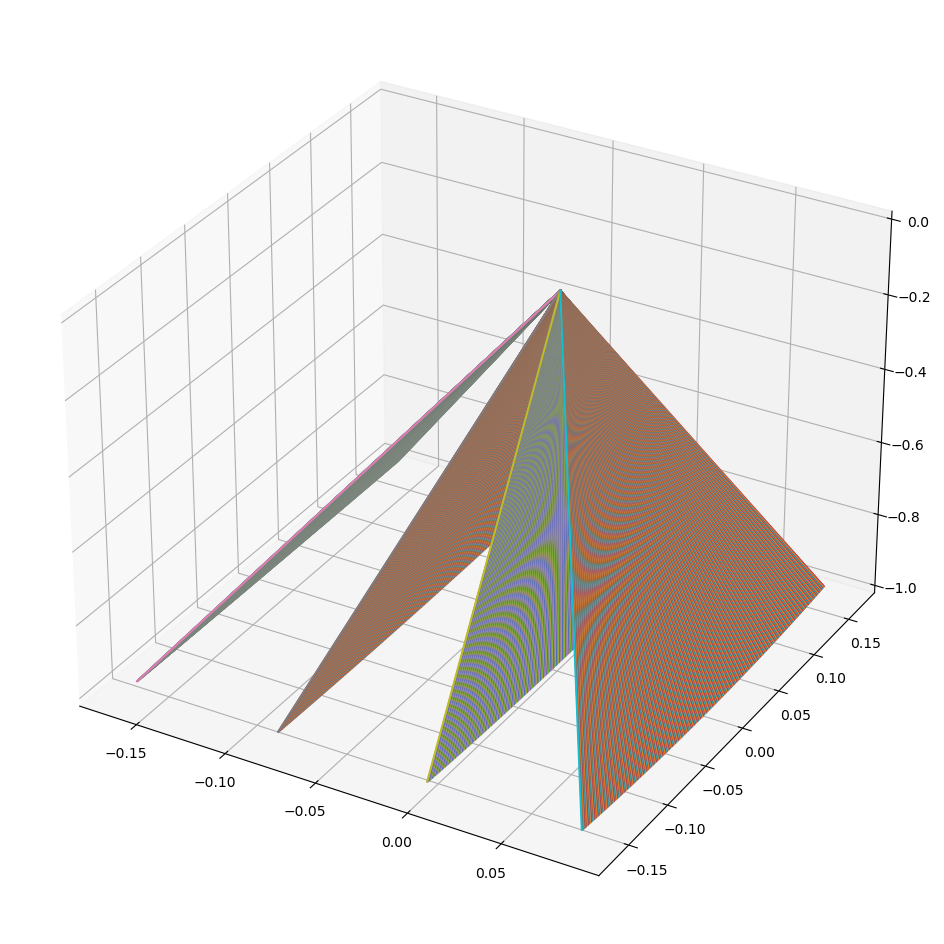

In [71]:
plot_rays(rays_o,rays_d,1)

In [72]:
class Sphere():
    def __init__(self, p, r, c):
        self.p=p
        self.r=r
        self.c=c

    def intersect(self, o, d):
        # for a given ray, this function tell us if the ray hits the sphere
        # also tells color

        #xc x center coord, yc y etc...

        # (x-xc)^2+(y-yc)^2+(z-zc)^2=r^2

        # to know whether a ray touches it, we have to see if their coor matches at one point:
        #x = ox+t*dx
        #y= oy+t*dy
        #z= oz+t*dz

        # if we plug that in sphere equation, we can solve a quadratic eq for t

        a = d[:, 0]**2 + d[:, 1]**2+ d[:, 2]**2 #dx^2+dy^2dz^2
        b= 2*((d[:,0]*(o[:,0]-self.p[0])) + (d[:,1]*(o[:,1]-self.p[1])) + (d[:,2]*(o[:,2]-self.p[2])))
        c=(o[:,0] - self.p[0])**2 + (o[:,2] - self.p[2])**2 + (o[:,1] - self.p[1])**2 - self.r**2

        
        pho=b**2 - 4*a*c # if pho is negative, no intersection. no t will lead to a point on the sphere

        cond = pho>=0
        num_rays=o.shape[0]

        colors=np.zeros((num_rays,3)) # standard color assigned to ray

        colors[cond] = self.c
        return colors

In [73]:
s=Sphere(np.array([0.,0.,1]), .1, np.array([1.,0.,0.]))

In [74]:
c=s.intersect(rays_o,rays_d)

In [75]:
img=c.reshape(H,W,3)

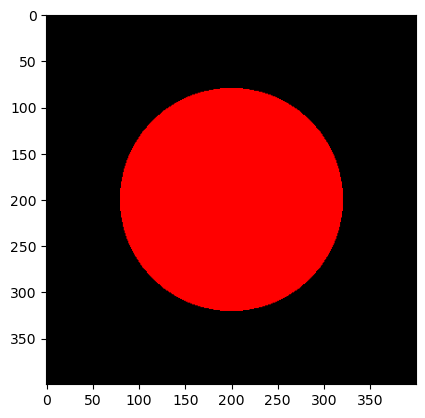

In [76]:
plt.imshow(img)

It is a 3D sphere projected on 2D!

Now it is time to implement volumetric rendering. It is expressed as follow:

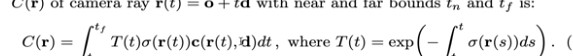

More specifically, we'll implement the following approximation:

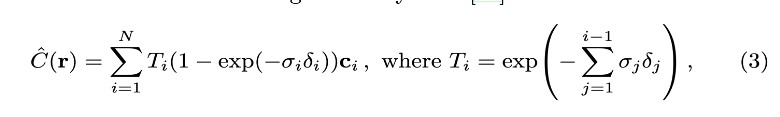

Which looks like that (the red line is C(r), the green boxes are \hat{C}(r)):

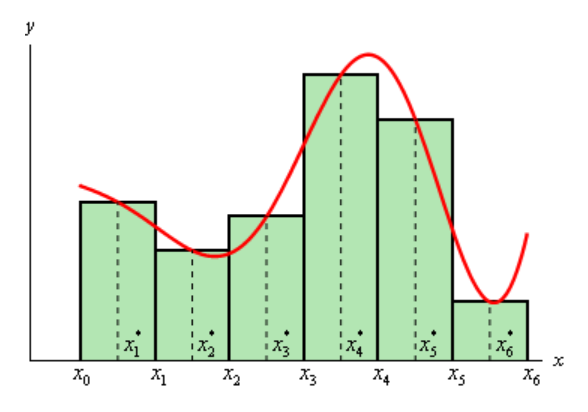

Before seeing how to approximate a function that outputs density and color for every points in space, let's look at a simpler example: the modified version of our sphere

In [77]:
class Sphere():
    def __init__(self, p, r, c):
        self.p=p
        self.r=r
        self.c=c

    def intersect(self, x):
        # Input: x 3D coordinate (rather than ray)
        # output density and color (per point)

        #Let s see how to tell if x is inside a sphere
        cond= (x[:,0]-self.p[0])**2+(x[:,1]-self.p[1])**2+(x[:,2]-self.p[2])**2< self.r**2 
        #p is the center of the sphere, r is the radius
        # if x is on a lower radius sphere, it will be inside the bigger sphere
        
        num_rays=x.shape[0]

        colors=torch.zeros((num_rays,3)) # standard color assigned to ray
        density=torch.zeros((num_rays,1))


        colors[cond] = self.c
        density[cond]=10
        return colors, density

In [78]:

#volume rendering
def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device="cpu"):
    #tn and tf are borns of integral (each are scalar?)
    #nb_bins is the number of points sampled?
    #rays_o origin of rays, Dim=(H*W,3)

    t=torch.linspace(tn,tf,nb_bins).to(device) # [nb_bins]
    delta=torch.cat((t[1:]-t[:-1] , torch.tensor([1e10]))) # we add infinity value at the end

    # Now we want to compute every point along the rays
    # naive approach:
    # rays_o+t*rays_d but the dimensions don t match

    x=rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1)*rays_d.unsqueeze(1) #[nb_rays,nb_bins,3]
    colors, density = model.intersect(x.reshape(-1,3))

    colors=colors.reshape(x.shape[0],nb_bins,3) # shape [nb_rays, nb_bins, 3]
    density=density.reshape(x.shape[0],nb_bins) # shape [nb_rays, nb_bins]

    alpha=1-torch.exp(-density * delta.unsqueeze(0)) # shape [nb_rays, nb_bins]
    T=accumulated_transmittance(1-alpha)
    print(T.shape)
    c=(T.unsqueeze(-1) * alpha.unsqueeze(-1) * colors).sum(1) #[nb_ray,3]
    return c

The creation of the points of rays goes in the following way:


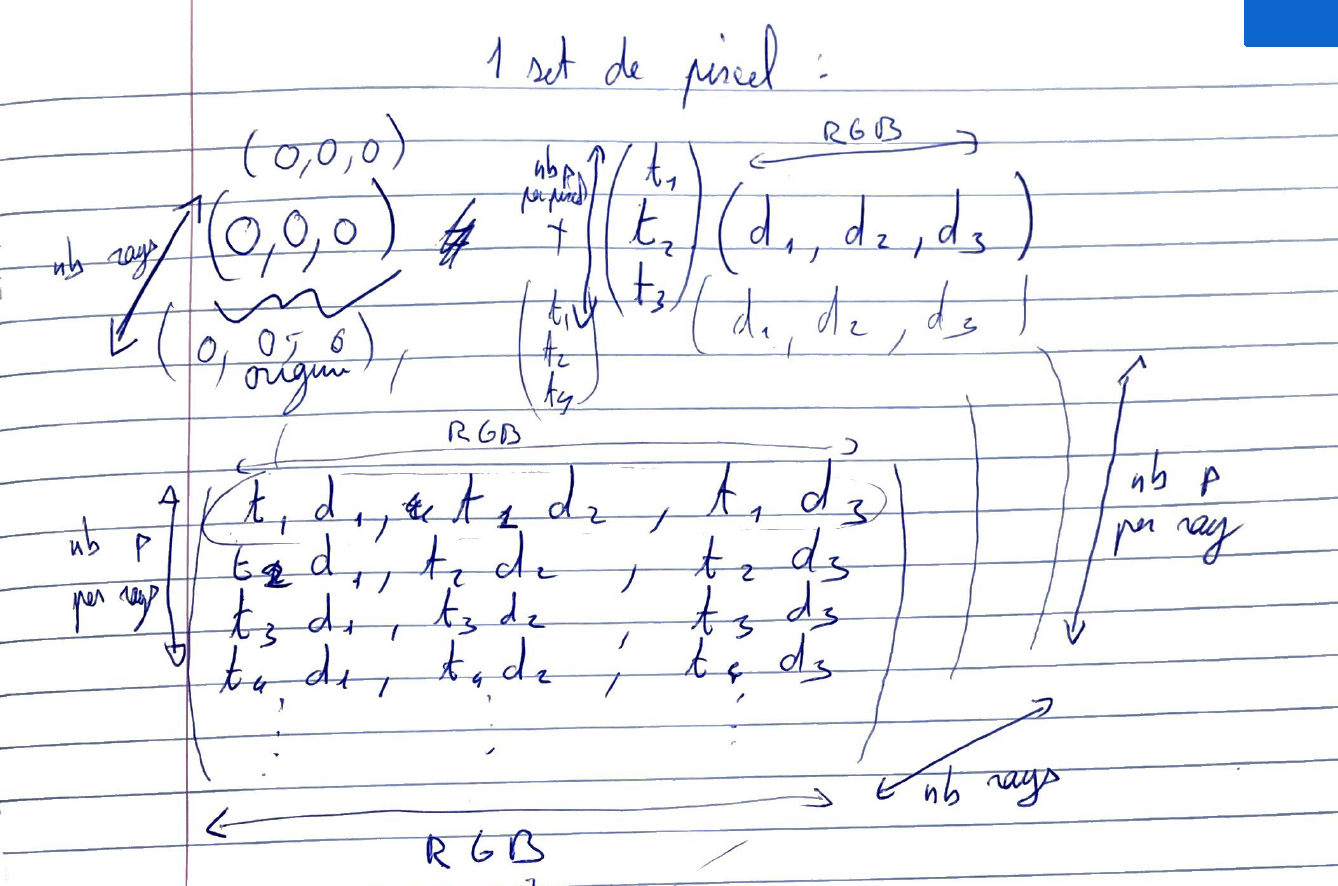

In a more schematic way:

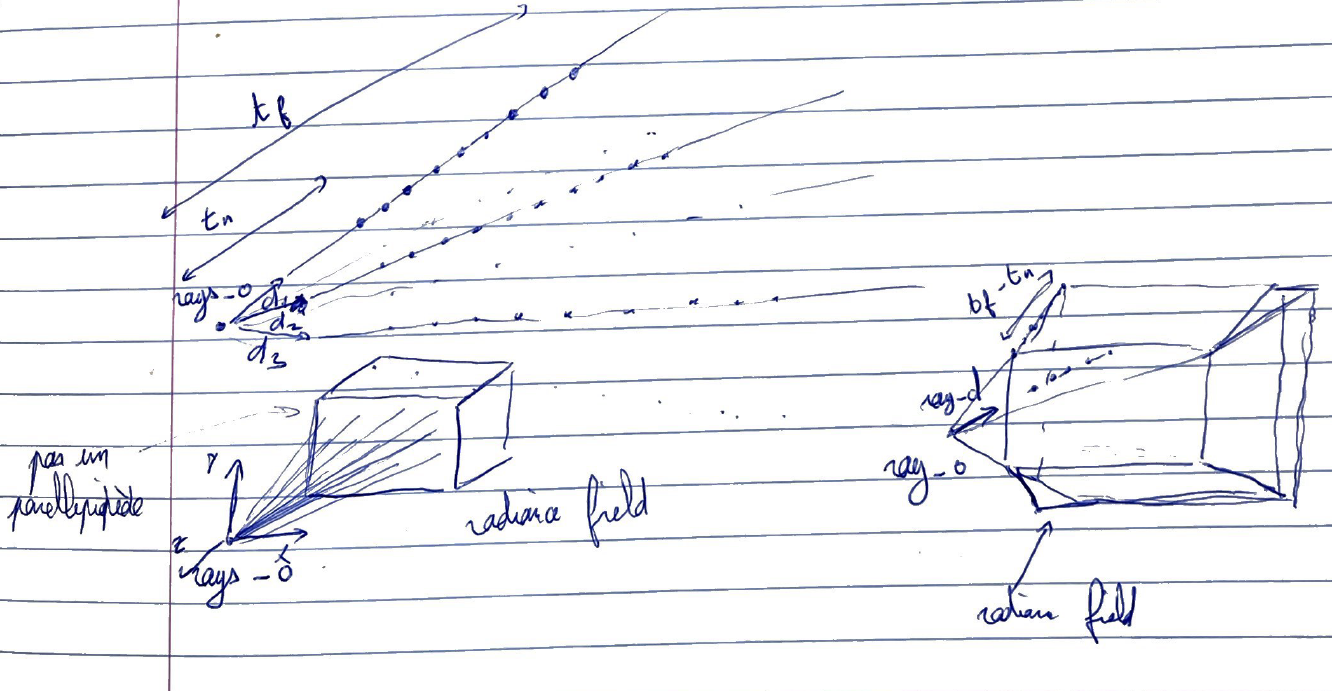

In [79]:
def accumulated_transmittance(beta):
    #beta = 1-alpha which is a trick to compute faster
    #input shape [nb_rays, nb_bins]
    #output shape [nb_rays, nb_bins]
    """
    T = torch.ones(beta.shape)
    for i in range(1,beta.shape[1]):
        T[:,i]=T[:,i-1]*beta[:,i-1]
    """

    #can be made faster using cumprod
    
    T=torch.cumprod(beta,1)
    #T[:,1:]=T[:,:-1] # might caus diff problems
    #T[:,0]=1.  might caus diff problems
    

    return torch.cat((torch.ones(T.shape[0],1, device=T.device),T[:,:-1]),dim=1)

In [80]:
tn=0.8
tf = 1.2
nb_bins=100
s=Sphere(torch.tensor([0.,0.,-1]), .1, torch.tensor([1.,0.,0.]))

In [81]:

px_colors=rendering(s,torch.from_numpy(rays_o), torch.from_numpy(rays_d), tn, tf)

torch.Size([160000, 100])


In [82]:
device="cpu"

t=torch.linspace(tn,tf,nb_bins).to(device) # [nb_bins]
delta=torch.cat((t[1:]-t[:-1] , torch.tensor([1e10]))) # we add infinity value at the end

# Now we want to compute every point along the rays
# naive approach:
# rays_o+t*rays_d but the dimensions don t match

x=torch.from_numpy(rays_o).unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1)*torch.from_numpy(rays_d).unsqueeze(1) #[nb_rays,nb_bins,3]
#colors, density = s.intersect(x.reshape(-1,3))

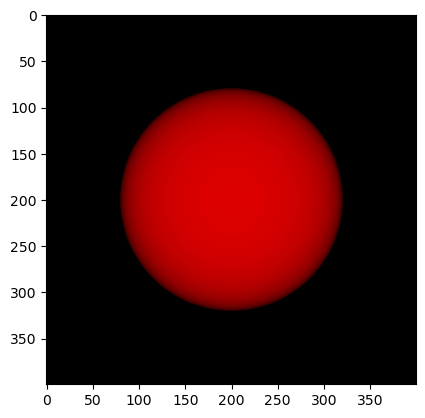

In [83]:
img=px_colors.reshape(H,W,3)
plt.imshow(img)

Let's make a little test of optimization.
Let's suppose we want to find the right color red starting from green

torch.Size([160000, 100])
torch.Size([160000, 100])


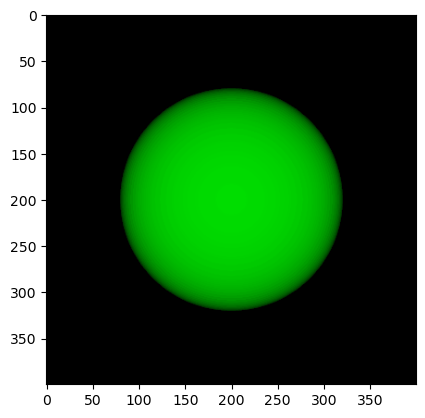

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


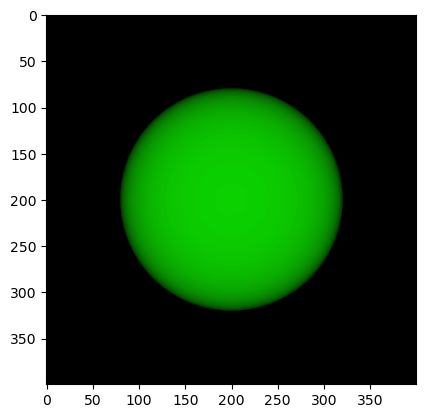

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


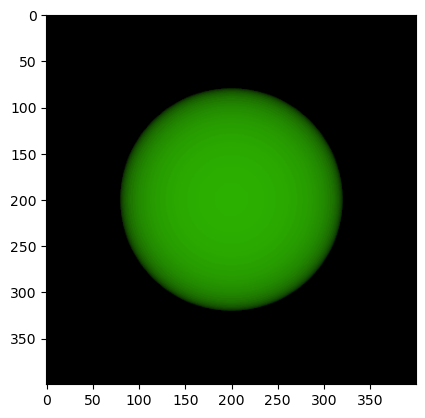

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


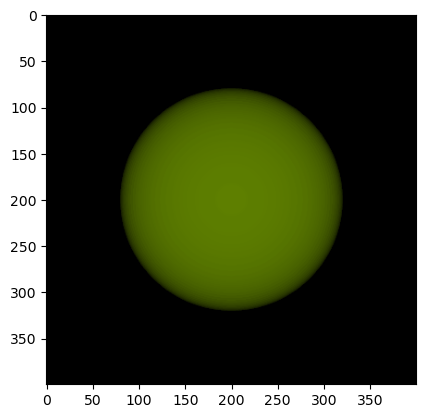

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


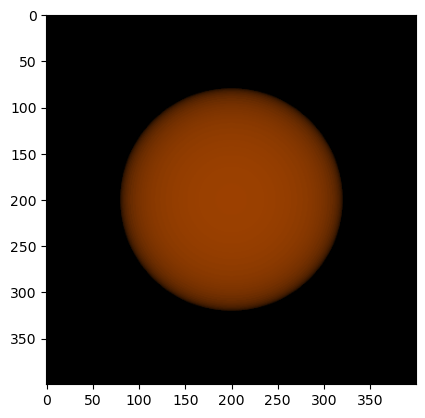

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


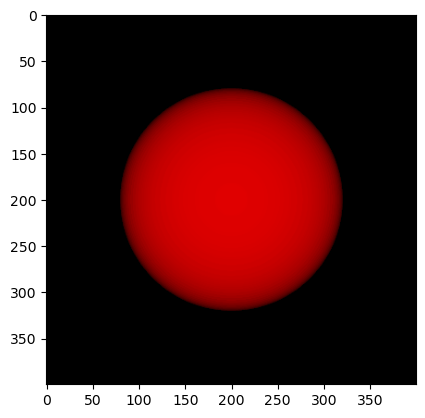

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([160000, 100])


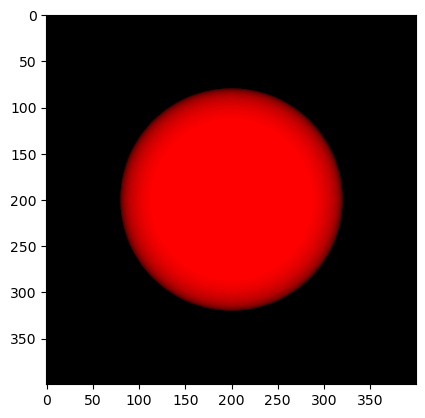

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


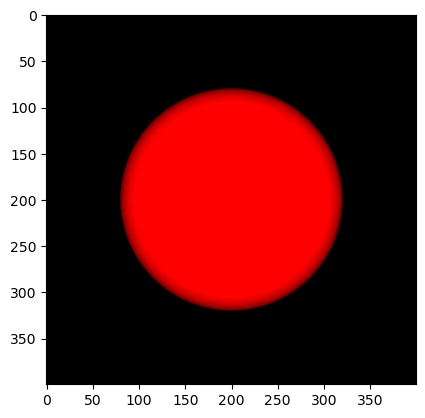

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


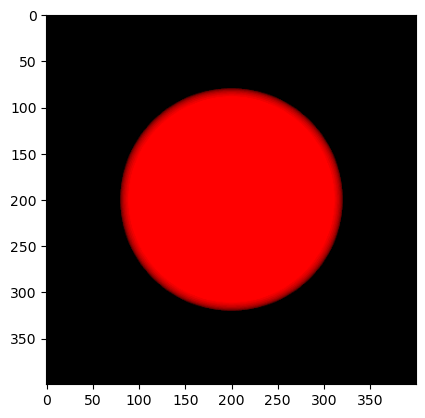

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


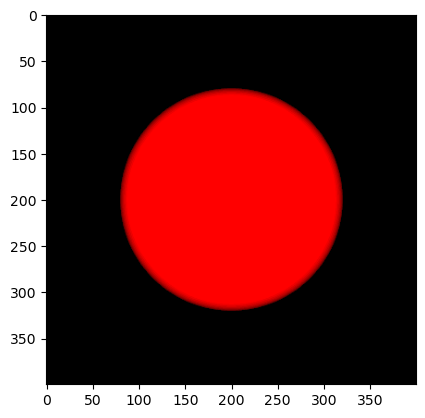

torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])
torch.Size([160000, 100])


In [84]:
color_opt=torch.tensor([0.,1.,0.], requires_grad=True)
s=Sphere(torch.tensor([0.,0.,-1]), .1, torch.tensor([1.,0.,0.]))
x= Sphere(torch.tensor([0.,0.,-1]), .1,color_opt)

b=rendering(s,torch.from_numpy(rays_o),torch.from_numpy(rays_d),tn,tf)

optimizer=torch.optim.SGD({color_opt},lr=1e-2)
for epoch in range(100):
    Ax=rendering(x,torch.from_numpy(rays_o),torch.from_numpy(rays_d),tn,tf)

    loss=((Ax-b)**2).mean()
    loss.backward()
    optimizer.step()

    if epoch %10 ==0:
        img=Ax.reshape(H,W,-1).cpu().data.numpy()
        plt.imshow(img)
        plt.show()




Now we want to be able to specify the position of a camera. We will use 4x4 matrices to that end. 
The first three rows and columns represents the rotation matrix, the three frist rows on the last column is the translation.
We'll simply apply the matrix by matrix multiplication to rays_o and rays_d